In [1]:

from qiskit import *
from qiskit import execute, BasicAer
from qiskit.quantum_info.synthesis import euler_angles_1q 
from qiskit.quantum_info.operators import Operator
from scipy.linalg import sqrtm 
from pyquil import *
from grove.alpha.arbitrary_state import arbitrary_state, unitary_operator
import numpy as np
import random
from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer
from sklearn import preprocessing 
%matplotlib inline

class dist_classifier:
    def __init__(self):
        self.ancilla = QuantumRegister(1)
        self.index = QuantumRegister(2)
        self.encoding = QuantumRegister(1)
        self.label = QuantumRegister(1)
        self.measure = ClassicalRegister(2)
        self.classifier = QuantumCircuit(self.encoding, self.ancilla, self.index, self.label, self.measure)
        self.classifier.h(self.ancilla)
        self.classifier.h(self.index)
        self.classifier.barrier()


    def C2Ugate(self, vctr):
        matrix = unitary_operator.unitary_operator(vctr)
        m = (self.create_control_gate(matrix, 3))
        self.classifier.unitary(m, [0,1,2,3], label = 'c2u')
        

    def da(self):
        dat = load_iris()  
        data = dat.data[:100, 2:]
        labels = dat.target[:100]

        #preprocessing:
        data = preprocessing.scale(data)
        data = preprocessing.normalize(data)
        #print(data)

        training_ind_X = random.sample(range(0,50), 3)
        training_ind_Y = random.sample(range(50,100), 3)
        xtrain = []
        ytrain = []

        for x in training_ind_X:
            xtrain.append(data[x])
        for x in training_ind_Y:
            ytrain.append(data[x])
        test_vctr = ytrain[2]
        test_lbl = 1
        print(xtrain)
        print(ytrain)
    
        return xtrain, ytrain, test_vctr, test_lbl
    
    def create_control_gate(self,U, num_control):
        l = 1
        num_tot = l + num_control
        CU = np.zeros((2**num_tot, 2**num_tot), dtype=complex)
        #print("CU: ", CU, "\nU:", U, "\n Num:", num_control, "\n Tot:", num_tot)
        ind = 2**num_tot - U.shape[0]
        for i in range(ind):
            CU[i][i] = 1
        for i in range(U.shape[0]):
            for j in range(U.shape[0]):
                CU[ind + i][ind + j] = U[i][j]
        return CU

    def encode(self):

        #encoding testsing vctr:
        matrix = unitary_operator.unitary_operator(test_vctr)
        m = (self.create_control_gate(matrix, 1))
        #print(matrix)
        #print(m)
        #angles = euler_angles_1q(matrix)
        #qiskit.quantum_info.synthesis.OneQubitEulerDecomposer(matrix).angles
        #classifier.cu3(angles[0], angles[1], angles[2], ancilla, encoding)
        self.classifier.unitary(m, [0,1], label = 'u1')
        self.classifier.x(self.ancilla)
        self.classifier.barrier()
        self.classifier.snapshot('1')

        self.C2Ugate(xtrain[0])
        self.classifier.barrier()
        self.classifier.x(self.index[0])
        self.classifier.barrier()
        self.C2Ugate(ytrain[0])
        self.classifier.barrier()
        self.classifier.ccx(self.index[0], self.index[1], self.label)
        self.classifier.barrier()
        self.classifier.x(self.index[0])
        self.classifier.x(self.index[1])
        self.classifier.barrier()
        self.C2Ugate(xtrain[1])
        self.classifier.barrier()
        self.classifier.x(self.index[0])
        self.classifier.barrier()
        self.C2Ugate(ytrain[0])
        self.classifier.barrier()
        self.classifier.ccx(self.index[0], self.index[1], self.label)
        self.classifier.barrier()

        self.classifier.h(self.ancilla)
        self.classifier.snapshot('2')
        self.classifier.measure(self.ancilla, self.measure[0])
        self.classifier.barrier()
        self.classifier.measure(self.label, self.measure[1])

        self.classifier.draw(output = 'mpl')
        return self.classifier

In [2]:





#backend = Aer.get_backend('statevector_simulator')
#result = execute(classifier, backend).result()
#snapshots = result.data()['snapshots']['statevector']
#print(snapshots)

In [3]:
correct = 0
for i in range(10):
    classifier = dist_classifier()
    xtrain, ytrain, test_vctr, test_lbl = classifier.da()
    c = classifier.encode()
    prob0 = 0
    prob1 = 0
    cl = 0
    for i in range(1000):
        simulator = Aer.get_backend('qasm_simulator')
        result = execute(c, backend = simulator, shots = 1).result()
        count = result.get_counts()
        res = list(count.keys())
        if res[0][1] == '0'and res[0][0] == '0':
            prob0 += 1
        elif res[0][1] == '0':
            prob1 += 1
            #print(res)
    if prob0 > prob1:
        cl = 0
        print("class=0")
        print(prob0, prob1)
    else:
        cl = 1
        print("class=1")
        print(prob0, prob1)
    if cl == test_lbl:
        correct += 1

    
print("corectly classifiedr=",correct)

[array([-0.74148939, -0.67096459]), array([-0.72035867, -0.69360175]), array([-0.80867259, -0.58825899])]
[array([0.4889688 , 0.87230127]), array([0.75857014, 0.65159139]), array([0.65376039, 0.75670163])]
class=1
1 467
[array([-0.64273312, -0.76609016]), array([-0.53868312, -0.84250846]), array([-0.69701269, -0.71705879])]
[array([0.66689611, 0.74515071]), array([0.91429915, 0.40503958]), array([0.73144187, 0.6819038 ])]
class=1
4 490
[array([-0.70740676, -0.70680667]), array([-0.76073534, -0.6490622 ]), array([-0.63882731, -0.76935016])]
[array([0.71258087, 0.70158998]), array([0.75857014, 0.65159139]), array([0.66689611, 0.74515071])]
class=1
1 475
[array([-0.64273312, -0.76609016]), array([-0.76073534, -0.6490622 ]), array([-0.78142267, -0.62400209])]
[array([0.66689611, 0.74515071]), array([0.737342  , 0.67551963]), array([0.71258087, 0.70158998])]
class=1
0 499
[array([-0.64273312, -0.76609016]), array([-0.80867259, -0.58825899]), array([-0.7865434 , -0.61753501])]
[array([0.6174

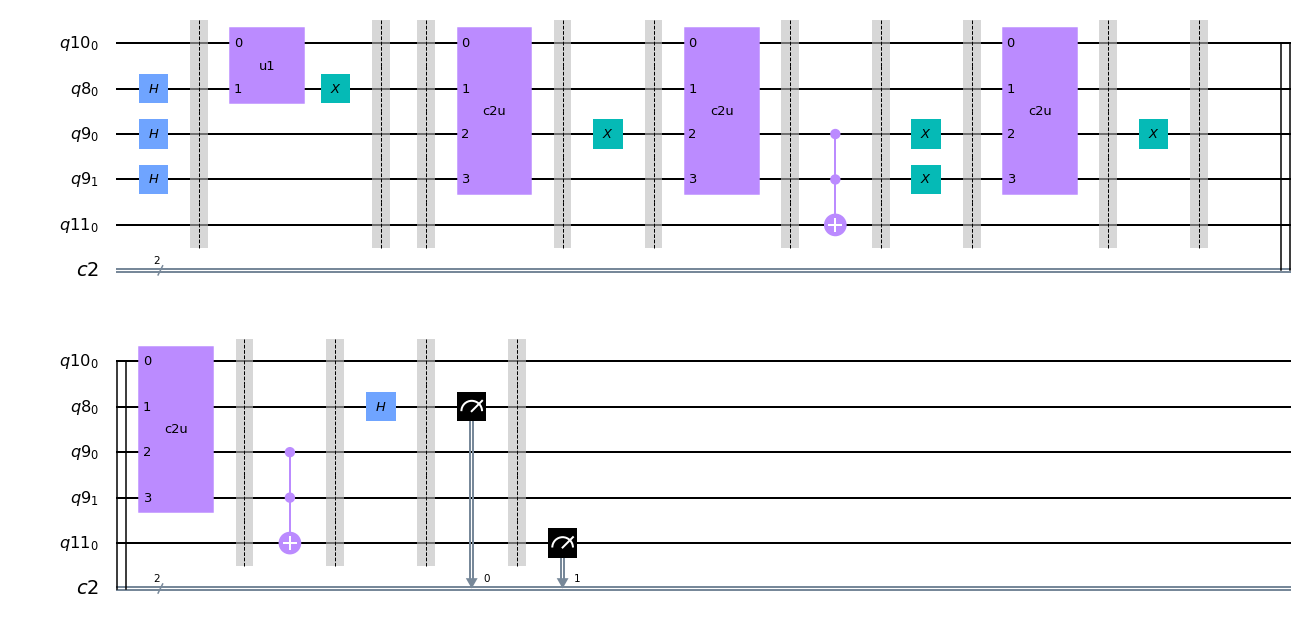

In [4]:
c.draw(output = 'mpl')